# Logic

In [1]:
# Import the usual stuff
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import plotly.express as px
import plotly

## Sellers

In [2]:
# Get sellers data, inspect
from olist.seller import Seller

In [3]:
sellers = Seller().get_training_data()

In [4]:
# For each seller, calculate: 1. Revenue, 2. Costs
# revenues = 80 * months_on_olist + 0.1 * sales
# costs = 100 * n_one_star + 50 * n_two_star + 40 * n_three_star
# profits = revenues - costs
# n_orders: already known

sellers['revenues'] = 80*sellers.months_on_olist + 0.1*sellers.sales

sellers['costs'] = 100 * sellers.n_one_star\
                  + 50 * sellers.n_two_star\
                  + 40 * sellers.n_three_star

sellers['profits'] = sellers.revenues - sellers.costs

In [5]:
# sort sellers by profit
sellers_ordered = (sellers[['n_orders', 'revenues', 'costs', 'profits']]
                   .sort_values('profits'))

In [6]:
# total revenue calculator
def total_revenue(df):
    return round(df.revenues.sum())

# total reputation cost calculator
def total_reputation_cost(df):
    return round(df.costs.sum())

# total it cost calculator
def total_it_cost(df):
    # 500,000 = it_factor * orders_before**0.5
    orders_before = sellers.n_orders.sum()
    it_factor = 500_000 / (orders_before**0.5)
    return round(it_factor * (df.n_orders.sum())**0.5)

# gross profit calculator
def gross_profit(df):
    return (total_revenue(df)
            - total_reputation_cost(df)
            - total_it_cost(df)
           )

In [7]:
# status before (P&L)

# define style (font size)
heading_properties = [('font-size', '18px')]
cell_properties = [('font-size', '16px')]
dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

# define P&L, apply style and color
PL_before = pd.DataFrame(
{"P&L" : [
    "{:,}".format(total_revenue(sellers)),
    "- {:,}".format(total_reputation_cost(sellers)),
    "- {:,}".format(total_it_cost(sellers)),
    "{:,}".format(gross_profit(sellers))
]},
index = ['Revenue', 'Reputation Cost', 'IT Cost', 'Gross Profit'])\
.style.set_table_styles(dfstyle)\
.applymap(lambda x : 'color: red' if x[0] == '-' else 'color: black')

In [8]:
# How are the bad reviews spread? What causes them?:
def plot_onestar_dist():
    plt.figure(figsize=(10,7))
    sns.histplot(sellers['share_of_one_stars'])
    plt.title('Distribution of "one star" reviews per seller')
    plt.ylabel('Number of Sellers')
    plt.xlabel('Share of "one star" reviews')
    plt.show()

In [9]:
# histogram seller profits
def plot_profit_per_seller():
    plt.figure(figsize=(10,7))
    sns.histplot(x='profits', data=sellers, bins = 50)
    plt.ylim(0,50)
    plt.title('Profit Distribution per Seller')
    plt.ylabel('Number of Sellers (capped at 50)')
    plt.xlabel('Profit per Seller')
    plt.axvline(x=0, color='r', linestyle='-', linewidth=3)
    plt.show()

In [10]:
# kick off x sellers, calculate gross profit
x = np.arange(0, len(sellers))
y = [gross_profit(sellers_ordered.iloc[i:, :]) for i in x]

In [11]:
# what is 95% of maximum (x+y)
for index, value in enumerate(y):
    if value > max(y) * 0.95:
        x_95 = index
        y_95 = value
        break
# -> Achieve 95% of max profit by only removing 188 instead of 600 sellers

In [12]:
# define profit plot function
def plot_profit(option='current'):
    # necessary to show plot in slides
    plotly.offline.init_notebook_mode(connected=True)
    fig = px.line(x=x, y=y,
          labels={
                 "x": "Number of sellers to remove",
                 "y": "Gross Profit (BRL)"
             },
          title='  Gross Profit after removal of x low performing sellers')
    if option == 'current':
        fig.add_annotation(
            x=0, y=y[0],
            xref="x",
            yref="y",
            text="Current Profit: {:,} BRL".format(y[0]),
            showarrow=True,
            arrowhead=1,
            arrowwidth=3,
            font=dict(
                #family="Courier New",
                size=14,
                color="#ffffff"
                ),
            ax=130,
            ay=0,
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor="#7a8ff5",
        )
    elif option == 'max':
        fig.add_annotation(
            x=600, y=max(y),
            xref="x",
            yref="y",
            text="Maximum Profit: {:,} BRL <br>Removed sellers: {}".format(max(y), 600),
            showarrow=True,
            arrowhead=1,
            arrowwidth=3,
            font=dict(
                #family="Courier New",
                size=14,
                color="#ffffff"
                ),
            ax=0,
            ay=50,
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor="#7a8ff5",
        )
    elif option == '95%':
        fig.add_annotation(
            x=x_95, y=y_95,
            xref="x",
            yref="y",
            text="95% of max profit: {:,} BRL <br>Removed sellers: {}".format(y_95, x_95),
            align = 'left',
            showarrow=True,
            arrowhead=1,
            arrowwidth=3,
            font=dict(
                #family="Courier New",
                size=14,
                color="#ffffff"
                ),
            ax=100,
            ay=50,
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor="#7a8ff5",
        )
    fig.show()

In [13]:
# P&L after, styled like above
PL_after = pd.DataFrame(
{"Before" : [
    "{:,}".format(total_revenue(sellers)),
    "- {:,}".format(total_reputation_cost(sellers)),
    "- {:,}".format(total_it_cost(sellers)),
    "{:,}".format(gross_profit(sellers))
],
"After" : [
    "{:,}".format(total_revenue(sellers_ordered.iloc[188:, :])),
    "- {:,}".format(total_reputation_cost(sellers_ordered.iloc[188:, :])),
    "- {:,}".format(total_it_cost(sellers_ordered.iloc[188:, :])),
    "{:,}".format(gross_profit(sellers_ordered.iloc[188:, :]))
]},
index = ['Revenue', 'Reputation Cost', 'IT Cost', 'Gross Profit'])\
.style.set_table_styles(dfstyle)\
.applymap(lambda x : 'color: red' if x[0] == '-' else 'color: black')

## Orders

In [14]:
# import orders dataset (for plot onestar odds)
from olist.order import Order
orders = Order().get_training_data(with_distance_seller_customer=True)

features = ['wait_time', 'delay_vs_expected', 'number_of_products', 'number_of_sellers', 'price',
       'distance_seller_customer']

/home/ruben/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
/home/ruben/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/ruben/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCop

In [15]:
# normalize
import scipy as sp

orders_norm = orders.copy()
orders_norm[features] = orders_norm[features].apply(sp.stats.zscore)

In [16]:
# build logistic regression model
formula_one = 'dim_is_one_star ~ + ' + ' + '.join(features)
logit_one = smf.logit(formula=formula_one, data=orders_norm).fit()

Optimization terminated successfully.
         Current function value: 0.273657
         Iterations 7


In [29]:
# plot model
def plot_onestar_odds():
    plt.figure(figsize=(10,7))
    logit_one.params[1:].plot(kind='bar')
    plt.ylabel("Impact on log odds")
    plt.title("Impact on odds for One Star review")

# Olist Presentation

### Data Analyst case study 

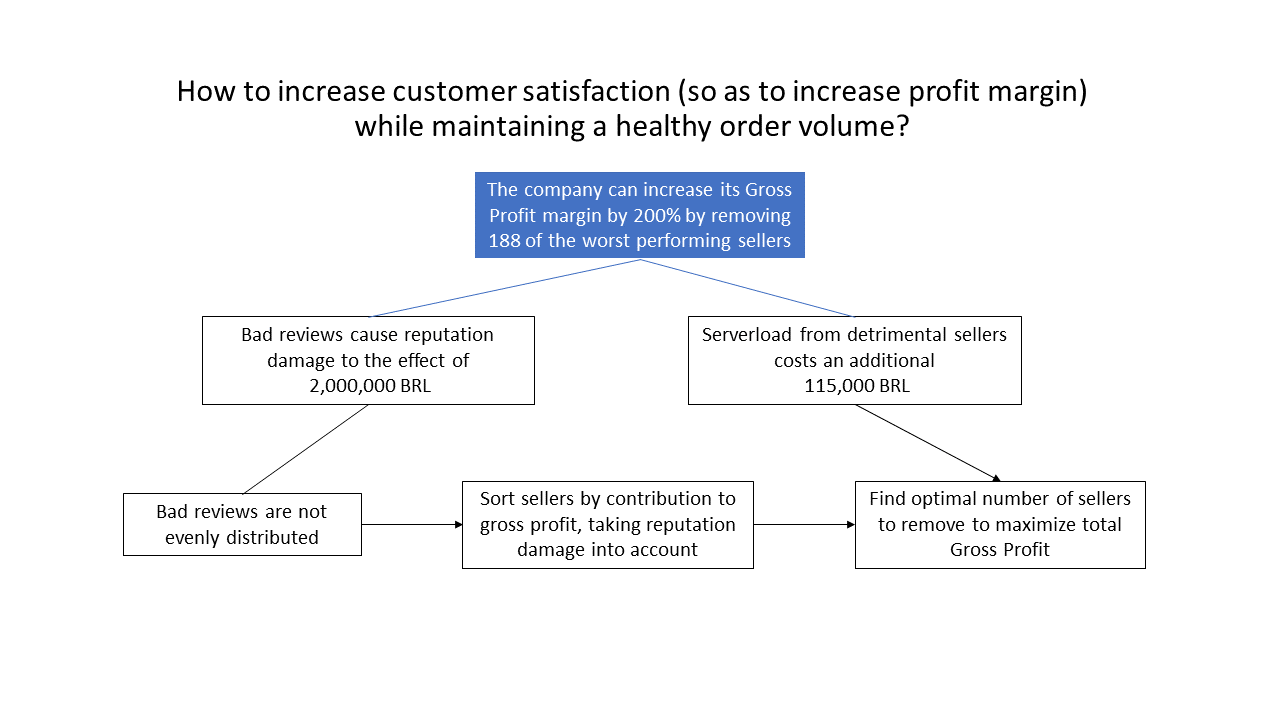

## Problem: Reputation damage through bad reviews

### Current P&L (2016 - 2018)

In [18]:
PL_before

,P&L
Revenue,"2,785,818"
Reputation Cost,"- 1,976,650"
IT Cost,"- 500,000"
Gross Profit,"309,168"


Reputation damage amounts to almost 2,000,000 BRL.

## Solution: Remove detrimental sellers and increase Gross Profit by 200%

In [19]:
PL_after

,Before,After
Revenue,"2,785,818","2,278,551"
Reputation Cost,"- 1,976,650","- 967,390"
IT Cost,"- 500,000","- 385,683"
Gross Profit,"309,168","925,478"


Side effect: reduced serverload from detrimental sellers saves an additional 115,000 BRL in IT costs.

## What is driving negative reviews?

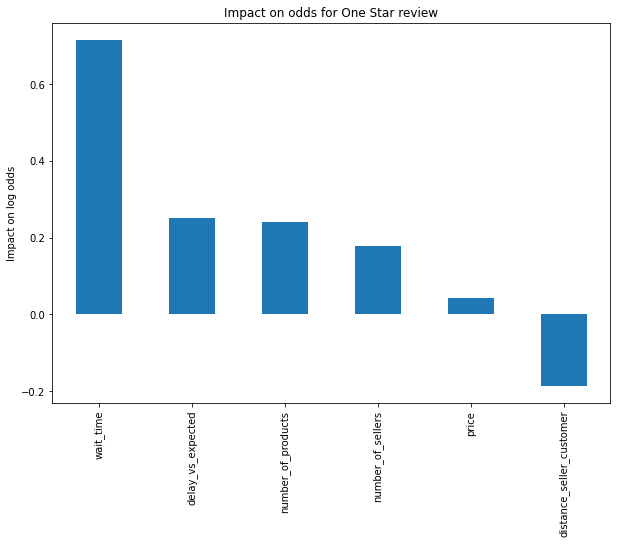

In [30]:
plot_onestar_odds()

## Who is causing the bad reviews?

### Reviews are not evenly distributed

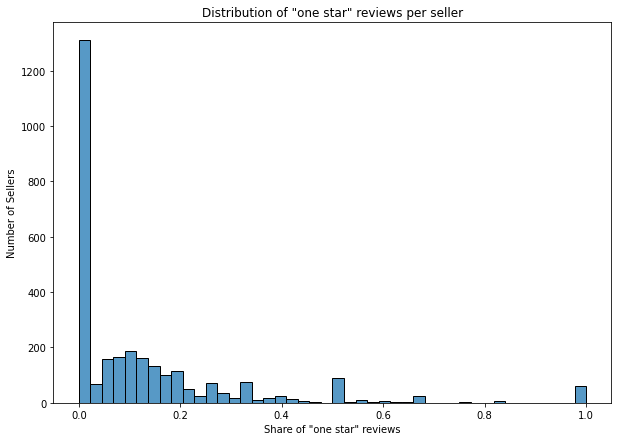

In [21]:
plot_onestar_dist()

### Wide range of profits per seller

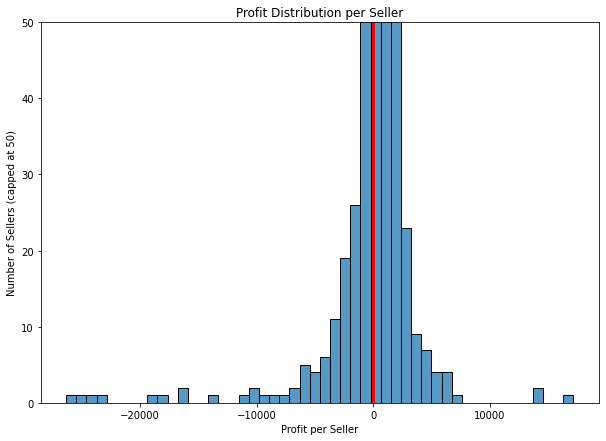

In [22]:
plot_profit_per_seller()

## Which sellers to remove?

### Current status: 3,000 sellers, 300,000 BRL Gross Profit

In [23]:
plot_profit(option='current')

### Maximum Profit

In [24]:
plot_profit(option='max')

### Balanced approach: 95% of max profit while removing only 188 sellers

In [25]:
plot_profit(option='95%')

## Conclusion

- Removing only 188 sellers can increase gross profit by 3x
- Healthy balance between profitability and order volume

In [26]:
PL_after

,Before,After
Revenue,"2,785,818","2,278,551"
Reputation Cost,"- 1,976,650","- 967,390"
IT Cost,"- 500,000","- 385,683"
Gross Profit,"309,168","925,478"
